# Imports librairies & données

## Librairies

In [1]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from matplotlib import colormaps 
import pandas as pd
from medpy.filter.smoothing import anisotropic_diffusion
from tqdm import tqdm
import os
import napari
from skimage import io
from skimage.util import crop
import extract
from shapely import convex_hull
from shapely import MultiPoint

C:\App\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## Image de base

In [3]:
image = io.imread("../data/rhizophagus/12/4/R12_23_06_P20.jpg")

In [4]:
img = image[:, :, 1]

img = crop(img, crop_width = 10)

## Graphe G

In [6]:
G = pickle.load(open('../data/rhizophagus/12/4/R12_23_06_P20.pkl', 'rb'))

In [7]:
pts = {n : G.nodes[n]["pts"][0] for n in G.nodes }
pts = {n : (y, -x) for n, (x, y) in pts.items()} 

## Thème

In [5]:
sns.set_theme(style = "whitegrid", context = "notebook", palette = "pastel")

# Fonctions de base à définir

In [3]:
def simple_graph(G):
    """
    Simplifies a graph by contracting paths of degree-2 nodes into single edges.
    The new edge's weight is the sum of the weights of the replaced edges.
 
    Parameters:
    G (networkx.Graph): Input graph with edge weights stored as "weight" attributes.
 
    Returns:
    networkx.Graph: Simplified graph.
    """
    # Identify nodes with degree ≠ 2
    main_nodes = {n for n in G.nodes if G.degree[n] != 2}
 
    # Subgraph of degree-2 nodes
    deg2_subgraph = G.subgraph(set(G.nodes) - main_nodes)
 
    # Find connected components of the degree-2 subgraph
    components = list(nx.connected_components(deg2_subgraph))
 
    # Create new edges connecting the endpoints of each component, summing their weights
    new_edges = []
    for component in components:
        component = set(component)  # Convert to set for fast lookup
        endpoints = set()
        total_weight = 0
 
        # Track visited edges to avoid double counting
        visited_edges = set()
 
        for node in component:
            for neighbor in G.neighbors(node):
                edge = tuple(sorted((node, neighbor)))  # Avoid direction issues
                if edge not in visited_edges:
                    weight = G[node][neighbor].get("weight", 1)  # Default weight = 1 if missing
                    total_weight += weight  # Sum each edge only once
                    visited_edges.add(edge)
 
                if neighbor not in component:
                    endpoints.add(neighbor)
 
        # Keep only neighbors that are not in the component (endpoints)
        endpoints = list(endpoints)
        if len(endpoints) == 2:  # Valid edge case
            new_edges.append((endpoints[0], endpoints[1], total_weight))
 
    # Construct the simplified graph
    H = G.copy()
    H.remove_nodes_from(deg2_subgraph.nodes)
    H.add_edges_from((u, v, {"weight": w}) for u, v, w in new_edges)
 
    return H

In [4]:
def fct_degrees(G) :
    degrees = G.degree()
    degrees = [val for (node, val) in G.degree()]
    d1 = np.array(degrees)
    return d1

In [5]:
def cycle_density(G):
    """
    Calculates the cycle density: number of independent cycles divided
    by the number of nodes or edges.
 
    Parameters
    ----------
    G : networkx.Graph
        The graph with node positions stored as the "pos" attribute.
 
    Returns
    -------
    float
        Cycle density
    """
    num_cycles = len(list(nx.cycle_basis(G)))
    num_nodes = G.number_of_nodes()
    return num_cycles / num_nodes

In [6]:
def spatial_density(G) :
    hyphal_length = total_hyphal_length(G)
    node_positions = {n : G.nodes[n]["pts"] for n in G.nodes } # ajouter [0] si liste de listes 
    node_positions = [tuple(pts) for pts in node_positions.values()]
    area = convex_hull(MultiPoint(node_positions)).area
    spatial_density = hyphal_length/area
    return spatial_density

In [7]:
def total_hyphal_length(G, weight="weight"):
    """Compute the total hyphal length in the network.
 
    If edges have a 'length' attribute, sum those. Otherwise, compute Euclidean distance.
    """
    total_length = 0.0
 
    for u, v, data in G.edges(data=True):
        if weight in data:
            total_length += data[weight]
        elif "pts" in G.nodes[u] and "pts" in G.nodes[v]:
            pos_u = np.array(G.nodes[u]["pts"])
            pos_v = np.array(G.nodes[v]["pts"])
            total_length += np.linalg.norm(pos_u - pos_v)
        else:
            raise ValueError("Edge length missing and node positions unavailable.")
 
    return total_length

# Preprocessing

In [ ]:
G.remove_edges_from(nx.selfloop_edges(G))

In [ ]:
fig, ax = plt.subplots(figsize = (14, 8)) 

nx.draw_networkx_edges(G, pos = pts, width = 1, alpha = 1, edge_color = "grey") 
nx.draw_networkx_nodes(G, pos = pts, node_size = 1, alpha = 0.5, node_color = "blue") #draw_networkx ou draw_networkx_edges/nodes

In [ ]:
nx.is_connected(G)

In [ ]:
# graphe une seule composante connectée
Gcc = sorted(nx.connected_components(G), key = len, reverse = True)
Gsub = G.subgraph(Gcc[0])

#highlight largest connected component
nx.draw_networkx_edges(Gsub, pos = pts, alpha = 0.4, width = 1, edge_color = "red")

#draw other connected component
for Gi in Gcc[1:] :
    if len(Gi) > 1 :
        nx.draw_networkx_edges(G.subgraph(Gi), pts, alpha = 0.4, width = 1, edge_color = "blue")

sb.despine(bottom = True, left = True)

In [ ]:
G_simplified = simple_graph(Gsub)

In [ ]:
fig, ax = plt.subplots(figsize = (14, 8)) 

nx.draw_networkx_edges(G_simplified, pos = pts, width = 1, alpha = 1, edge_color = "gray") 
nx.draw_networkx_nodes(G_simplified, pos = pts, node_size = 1, alpha = 0.5, node_color = "blue")

In [ ]:
for n in G_simplified.nodes:
    if 'pts' not in G_simplified.nodes[n] and 'pts' in Gsub.nodes[n]:
        G_simplified.nodes[n]['pts'] = Gsub.nodes[n]['pts']

In [ ]:
for n in G_simplified.nodes:
    pts = np.array(G_simplified.nodes[n]["pts"])
    if pts.ndim == 2 and pts.shape[1] == 2:
        pts = np.mean(pts, axis=0)
    elif pts.ndim != 1 or pts.shape[0] != 2:
        raise ValueError(f"Node {n} has unsupported shape {pts.shape}")
    G_simplified.nodes[n]["pts"] = tuple(pts)

# Nettoyer le graphe

In [ ]:
G_clean = G.copy()

In [ ]:
to_remove = [(u, v) for u, v, d in G_clean.edges(data=True) if d.get('weight', 0) < 25 and (G_clean.degree[u] == 1 or G_clean.degree[v] == 1)]
G_clean.remove_edges_from(to_remove)

In [ ]:
G_clean_cc = sorted(nx.connected_components(G_clean), key = len, reverse = True)
G_clean_sub = G_clean.subgraph(G_clean_cc[0])

In [ ]:
G_clean_simple = simple_graph(G_clean_sub)

In [ ]:
for n in G_clean_simple.nodes:
    if 'pts' not in G_clean_simple.nodes[n] and 'pts' in G_clean_sub.nodes[n]:
        G_clean_simple.nodes[n]['pts'] = G_clean_sub.nodes[n]['pts']

In [ ]:
for n in G_clean_simple.nodes:
    pts = np.array(G_clean_simple.nodes[n]["pts"])
    if pts.ndim == 2 and pts.shape[1] == 2:
        pts = np.mean(pts, axis=0)
    elif pts.ndim != 1 or pts.shape[0] != 2:
        raise ValueError(f"Node {n} has unsupported shape {pts.shape}")
    G_clean_simple.nodes[n]["pts"] = tuple(pts)

In [ ]:
G_clean_simple.number_of_nodes()

In [ ]:
G_clean_simple.number_of_edges()

In [ ]:
len(nx.cycle_basis(G_clean_simple))

In [ ]:
cycle_density(G_clean_simple)

In [ ]:
l_degrees = [val for (node, val) in G_clean_simple.degree()]
d1 = np.array(l_degrees)
bins = np.arange(1, 10, 1)
#arranger les bins
plt.hist([d1], bins = bins, density = False) #density pour mettre en probabilités
plt.title("Degrees distribution")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.show()

## Visualisation (Napari et notebook)

In [ ]:
points_G = np.array([G_simplified.nodes[n]['pts'] for n in G_simplified.nodes])

edges_G = []
for u, v in G_simplified.edges():
    pt_u = G_simplified.nodes[u]['pts']
    pt_v = G_simplified.nodes[v]['pts']
    edges_G.append([pt_u, pt_v])
edges_G = np.array(edges_G)

In [ ]:
points_clean = np.array([G_clean_simple.nodes[n]['pts'] for n in G_clean_simple.nodes])

edges_clean = []
for u, v in G_clean_simple.edges():
    pt_u = G_clean_simple.nodes[u]['pts']
    pt_v = G_clean_simple.nodes[v]['pts']
    edges_clean.append([pt_u, pt_v])
edges_clean = np.array(edges_clean)

In [ ]:
viewer = napari.Viewer()

viewer.add_image(img, name = "raw image")

viewer.add_points(points_G, name="nodes", size=10, face_color="blue", border_color="gray")
viewer.add_shapes(edges_G, shape_type="line", edge_color="white", edge_width=1, name="edges")

viewer.add_points(points_clean, name="nodes", size=10, face_color="yellow", border_color="gray")
viewer.add_shapes(edges_clean, shape_type="line", edge_color="lime", edge_width=1, name="edges")

napari.run()

In [ ]:
pts_nx = {n: tuple(G_clean_simple.nodes[n]["pts"]) for n in G_clean_simple.nodes}
pts_nx = {n : (y, -x) for n, (x, y) in pts_nx.items()}

In [ ]:
fig, ax = plt.subplots(figsize = (14, 8)) 

nx.draw_networkx_edges(G_clean_simple, pos = pts_nx, width = 1, alpha = 1, edge_color = "grey") 
nx.draw_networkx_nodes(G_clean_simple, pos = pts_nx, node_size = 1, alpha = 0.5, node_color = "blue")

# Mesures de base

In [4]:
G = pickle.load(open('../data/rhizophagus/12/4/R12_23_06_P10.pklclean', 'rb'))

In [5]:
pts = {n : G.nodes[n]["pts"] for n in G.nodes }
pts = {n : (y, -x) for n, (x, y) in pts.items()} 

## Nombre de nodes

In [15]:
nodes = G.number_of_nodes()
nodes

4116

## Nombre de edges

In [16]:
edges = G.number_of_edges()
edges

5024

## Distribution des degrés

In [17]:
degrees = G.degree()

In [18]:
dict_nodes = dict()
 
for x, y in degrees :
    dict_nodes.setdefault(x, []).append(y)
print(dict_nodes)

{0: [1], 1: [1], 9: [1], 10: [1], 13: [1], 17: [1], 21: [1], 23: [1], 25: [1], 29: [1], 33: [1], 34: [1], 35: [1], 39: [2], 41: [1], 47: [3], 50: [3], 57: [3], 58: [3], 65: [2], 70: [3], 72: [3], 73: [3], 77: [1], 80: [1], 82: [1], 84: [3], 94: [3], 115: [1], 116: [3], 119: [2], 120: [1], 123: [3], 124: [3], 133: [3], 137: [3], 139: [4], 141: [1], 142: [3], 144: [3], 145: [2], 147: [3], 150: [3], 151: [1], 153: [3], 155: [4], 157: [1], 158: [3], 162: [3], 170: [1], 171: [3], 172: [3], 182: [3], 187: [1], 188: [1], 195: [1], 196: [3], 198: [3], 208: [3], 217: [1], 222: [1], 224: [3], 229: [3], 232: [3], 240: [1], 241: [1], 248: [1], 249: [1], 250: [3], 254: [1], 257: [3], 259: [3], 261: [3], 263: [3], 268: [3], 270: [3], 271: [1], 272: [3], 274: [1], 275: [1], 276: [3], 277: [1], 282: [3], 286: [3], 291: [3], 299: [3], 312: [1], 313: [1], 314: [1], 315: [1], 322: [3], 323: [1], 326: [3], 327: [4], 331: [1], 332: [1], 334: [3], 346: [3], 350: [3], 352: [3], 353: [3], 360: [1], 365: [1], 

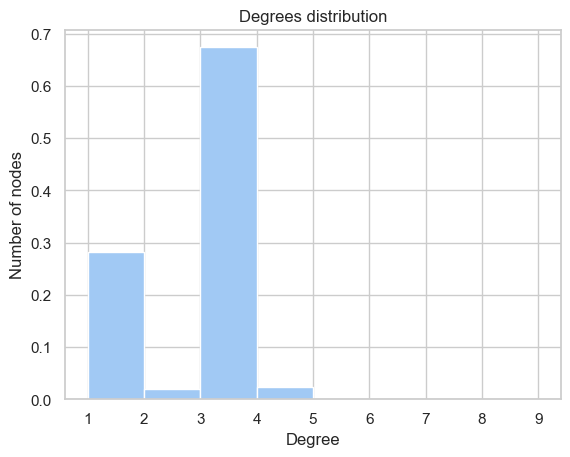

In [19]:
l_degrees = [val for (node, val) in G.degree()]
d1 = np.array(l_degrees)
bins = np.arange(1, 10, 1)
#arranger les bins
plt.hist([d1], bins = bins, density = True) #density pour mettre en probabilités
plt.title("Degrees distribution")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.show()

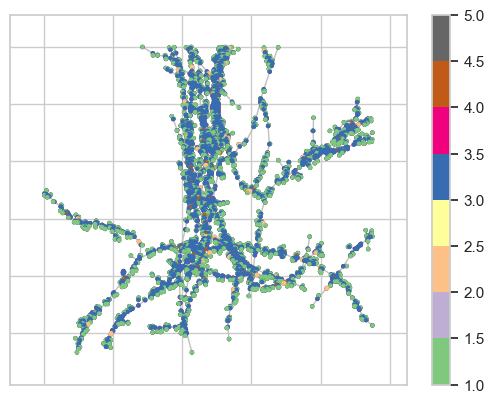

In [30]:
params = {"node_size" : 5,
          "with_labels" : False,
          "edge_color" : "silver"
         }
degrees = G.degree()
nodes = G.nodes()
n_color = np.asarray([degrees[n] for n in nodes])

nx.draw_networkx(G, pos = pts, **params, node_color = n_color, label = degrees) 

collection = nx.draw_networkx_nodes(G, pos = pts, node_color = n_color, label = degrees, node_size = 5, cmap = 'Accent') 
plt.colorbar(collection) 

## Densité des cycles

In [31]:
c_density = cycle_density(G)
c_density

0.22084548104956267

## Longueur totale d'hyphes

In [32]:
hyphal_length = total_hyphal_length(G)
hyphal_length

205831.0550801066

## Densité spatiale

In [33]:
s_density = spatial_density(G)
s_density

0.004780829115899233

# Autres mesures

## Distribution des longueurs d'edges

In [4]:
def distance(G, node1, node2):
    """Helper function to calculate distance between two nodes"""
    return np.linalg.norm(
        np.array(G.nodes[node1]["pts"]) - np.array(G.nodes[node2]["pts"])
    )

In [35]:
# avant de calculer distances
# déjà dans la boucle
for n in G.nodes:
    pts = np.array(G.nodes[n]["pts"])
    if pts.ndim == 2 and pts.shape[1] == 2:
        pts = np.mean(pts, axis=0)
    elif pts.ndim != 1 or pts.shape[0] != 2:
        raise ValueError(f"Node {n} has unsupported shape {pts.shape}")
    G.nodes[n]["pts"] = tuple(pts)

In [36]:
dist = distance(G, 0, 1)
dist

1414.0

In [37]:
edge_lengths = {}

for u, v in G.edges():
    dist = distance(G, u, v)
    edge_lengths[(u, v)] = dist

In [3]:
def edges_lengths(G) :
    for u, v in G.edges():
        dist = distance(G, u, v)
        edges_lengths[(u, v)] = dist
    return edges_lengths

In [39]:
values = list(edge_lengths.values())

np.median(values)

27.41579276833221

<Axes: ylabel='Count'>

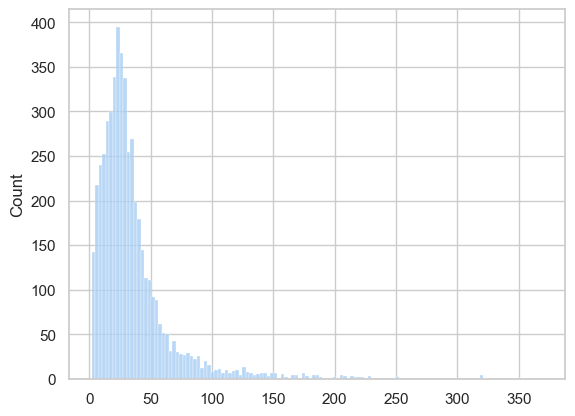

In [40]:
sns.histplot(edge_lengths)
# plt.savefig('edge_lengths.png')

## Coefficient de clustering

In [ ]:
clustering_c = nx.clustering(G)
clustering_c

In [ ]:
average_clustering = nx.average_clustering(G)
average_clustering

## Betweenness centrality

In [ ]:
bc = nx.betweenness_centrality(G) #139 secondes
bc

## Shortest path

In [ ]:
all_shortest_path = dict(nx.all_pairs_shortest_path_length(G)) #81secondes, bcp de mémoire
all_shortest_path

In [ ]:
shortest_path_dist = dict(nx.all_pairs_dijkstra_path_length(G))
shortest_path_dist

In [ ]:
sb.histplot(shortest_path_dist) #pas assez de mémoire

## Diamètre

In [ ]:
diameter = nx.diameter(G) #résultat en edges
diameter

In [ ]:
diameter_dist = nx.diameter(G, weight = "weight") #résultat en distance réelle, 131 secondes
diameter_dist

## Average shortest path

In [ ]:
average_shortest_path = nx.average_shortest_path_length(G) #résultat en edges pas en distance réelle
average_shortest_path

In [ ]:
average_shortest_path_dist = nx.average_shortest_path_length(G, weight = "weight") #distance réelle, 120 secondes mais bcp mémoire
average_shortest_path_dist

## Minimum spanning tree

In [ ]:
mst = nx.minimum_spanning_tree(G)

In [ ]:
fig, ax = plt.subplots(figsize = (5,5)) 

nx.draw_networkx_edges(mst, pos = pos, width = 1, alpha = 1) 
nx.draw_networkx_nodes(mst, pos = pos, node_size = 1, alpha = 0.5)

## Global efficiency weighted

In [5]:
def global_efficiency_weighted(G, weight="weight"):

    """

    compute the global efficiency of a weighted graph.
 
    Parameters

    ----------

    G : networkx.Graph

        graph where edges may have weights representing distances or costs.

    weight : str, optional

        name of the edge attribute to use as weight (default is "weight").
 
    Returns

    -------

    g_eff : float

        global efficiency of the graph, defined as the average of the 

        inverse shortest path lengths between all pairs of nodes.

    """
 
    # adapted from networkx to take weights into account
 
    N = len(G)

    n_paths = N * (N - 1)  # total number of ordered node pairs
 
    if N > 5000:

        print("too large:", G)

        return np.nan, np.nan
 
    if n_paths == 0 :

        return 0, 0
 
    node_pos = {n : np.array(G.nodes[n]["pts"]) for n in G.nodes}
 
    g_eff = 0

    average_length = 0

    g_eff_euclid = 0
 
    lengths = nx.all_pairs_dijkstra_path_length(G, weight=weight, backend="parallel")  # compute shortest paths

    for source, targets in lengths:

        for target, length_sp in targets.items():

            if length_sp > 0:  # avoid self-loops

                g_eff += 1 / length_sp

                average_length += length_sp 
 
                length_euclid = np.linalg.norm(node_pos[target] - node_pos[source])

                g_eff_euclid += 1 / length_euclid
 
    g_eff /= n_paths

    g_eff_euclid /= n_paths

    average_length /= n_paths
 
    return g_eff if g_eff==0 else g_eff / g_eff_euclid, average_length

In [42]:
g_eff, average_length = global_efficiency_weighted(G)

In [43]:
g_eff

0.710112821161879

In [44]:
average_length

3905.6952267334555

## Local efficiency weighted

In [6]:
def local_efficiency_weighted(G):

    """Returns the average local efficiency of the graph.
 
    The *efficiency* of a pair of nodes in a graph is the multiplicative

    inverse of the shortest path distance between the nodes. The *local

    efficiency* of a node in the graph is the average global efficiency of the

    subgraph induced by the neighbors of the node. The *average local

    efficiency* is the average of the local efficiencies of each node [1]_.
 
    Parameters

    ----------

    G : :class:`networkx.Graph`

        An undirected graph for which to compute the average local efficiency.
 
    Returns

    -------

    float

        The average local efficiency of the graph.
 
    Examples

    --------
>>> G = nx.Graph([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3)])
>>> nx.local_efficiency(G)

    0.9166666666666667
 
    Notes

    -----

    Edge weights are ignored when computing the shortest path distances.
 
    See also

    --------

    global_efficiency
 
    References

    ----------

    .. [1] Latora, Vito, and Massimo Marchiori.

           "Efficient behavior of small-world networks."

           *Physical Review Letters* 87.19 (2001): 198701.
<https://doi.org/10.1103/PhysRevLett.87.198701>
 
    """

    N = len(G)

    efficiency = (global_efficiency_weighted(G.subgraph(G[v])) for v in G)

    efficiency_list, _ = zip(*efficiency)

    return sum(efficiency_list) / N

In [57]:
local_efficiency_weighted(G)

0.1263428456368645

## Robustness

In [7]:
def robustness_curve(G, root_node=0, n_steps=20, mode="uniform", seed=None, n_reps=10, max_fraction_rm=1):

    """

    Compute robustness curve: percentage of total network length

    connected to root node as a function of fraction of edge length removed.

    Averaged over multiple repetitions.
 
    Parameters:

        G : networkx.Graph

            The input graph with edge attribute 'weight'.

        root_node : node label

            The node considered as the root.

        n_steps : int

            Number of removal steps between 0 and 1.

        mode : str

            'uniform' (default) or 'length_weighted' for removal probability.

        seed : int or None

            Random seed for reproducibility.

        n_reps : int

            Number of repetitions to average over.
 
    Returns:

        fractions_removed : np.ndarray

        fractions_connected_mean : np.ndarray

    """
 
    rng = np.random.seed(seed)
 
    edges = list(G.edges(data=True))

    weights = np.array([attr['weight'] for (_, _, attr) in edges])

    total_length = weights.sum()
 
    fractions_removed = np.linspace(0, max_fraction_rm, n_steps)

    all_fractions_connected = []
 
    for _ in range(n_reps):

        fractions_connected = []
 
        for fraction in fractions_removed:

            G_copy = G.copy()
 
            n_edges_to_remove = int(fraction * len(edges))
 
            if n_edges_to_remove > 0:

                if mode == "uniform":

                    selected_indices = np.random.choice(len(edges), size=n_edges_to_remove, replace=False)

                elif mode == "length_weighted":

                    probabilities = weights / weights.sum()

                    selected_indices =  np.random.choice(len(edges), size=n_edges_to_remove, replace=False, p=probabilities)

                else:

                    raise ValueError("Unknown mode: choose 'uniform' or 'length_weighted'")
 
                edges_to_remove = [edges[i][:2] for i in selected_indices]

                G_copy.remove_edges_from(edges_to_remove)
 
            # Get connected component containing root node

            if root_node in G_copy:

                components = nx.node_connected_component(G_copy, root_node)

                subgraph = G_copy.subgraph(components)

                connected_length = sum(nx.get_edge_attributes(subgraph, 'weight').values())

            else:

                connected_length = 0.0
 
            fractions_connected.append(connected_length / total_length)
 
        all_fractions_connected.append(fractions_connected)
 
    fractions_connected_mean = np.mean(all_fractions_connected, axis=0)
 
    return fractions_removed, fractions_connected_mean
 
 
def robustness_score(fractions_removed, fractions_connected, mode="auc", target_fraction=0.5):

    """

    Summarize a robustness curve into a single number.
 
    Parameters:

        fractions_removed : np.ndarray

        fractions_connected : np.ndarray

        mode : str

            'auc' (default) to compute area under the curve (normalized),

            or 'target_fraction' to find the fraction removed when

            connected component drops below target_fraction.

        target_fraction : float

            Target fraction for 'target_fraction' mode (default 0.5).
 
    Returns:

        summary_value : float

    """

    if mode == "auc":

        auc = np.trapz(fractions_connected, fractions_removed)

        max_auc = 1.0 * 1.0  # maximum area = 1*1

        return auc / max_auc
 
    elif mode == "target_fraction":

        below_target = fractions_connected <= target_fraction

        if np.any(below_target):

            idx = np.argmax(below_target)

            return fractions_removed[idx]

        else:

            return 1.0  # never dropped below target, very robust
 
    else:

        raise ValueError("Unknown mode: choose 'auc' or 'target_fraction'")
 

In [59]:
ans = robustness_curve(G)
ans

(array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 array([1.00000000e+00, 5.86551891e-01, 2.90290021e-01, 1.00482049e-02,
        2.61339939e-02, 2.78083210e-03, 2.25898571e-03, 3.60131188e-03,
        1.79896009e-03, 7.54690329e-04, 1.30078651e-03, 1.11197212e-03,
        7.59902332e-04, 7.15456013e-04, 5.88889682e-04, 7.60883120e-04,
        1.71993439e-04, 1.71993439e-04, 0.00000000e+00, 0.00000000e+00]))

In [60]:
robustness_score(ans[0], ans[1])

0.07525267197525236

# Boucle : simplification des graphes et métriques de base

In [8]:
metrics_functions = {
    'nodes' : nx.number_of_nodes,
    'edges' : nx.number_of_edges,
    'degrees' : fct_degrees,
    'cycle density' : cycle_density,
    'total hyphal length' : total_hyphal_length,
    'spatial density' : spatial_density
}

In [9]:
network_path = []

for sp in os.listdir("../data"):
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith("pkl") :
                    path = os.path.join("../data", sp, boite, mesure, photo)
                    network_path.append(path)

In [10]:
for path in tqdm(network_path) :
    save_dir = os.path.dirname(path)
    graph_name = os.path.splitext(os.path.basename(path))[0]
    graph_path = os.path.join(save_dir, f"{graph_name}.pklclean" )

    if os.path.exists(graph_path) :
        continue
    
    G = pickle.load(open(path, 'rb'))
    G.remove_edges_from(nx.selfloop_edges(G))
    to_remove = [(u, v) for u, v, d in G.edges(data=True) if d.get('weight', 0) < 25 and (G.degree[u] == 1 or G.degree[v] == 1)]
    G.remove_edges_from(to_remove)
    G_cc = sorted(nx.connected_components(G), key = len, reverse = True)
    G_sub = G.subgraph(G_cc[0])
    G_simple = simple_graph(G_sub)
    for n in G_simple.nodes:
        if 'pts' not in G_simple.nodes[n] and 'pts' in G_sub.nodes[n]:
            G_simple.nodes[n]['pts'] = G_sub.nodes[n]['pts']

    for n in G_simple.nodes:
        pts = np.array(G_simple.nodes[n]["pts"])
        if pts.ndim == 2 and pts.shape[1] == 2:
            pts = np.mean(pts, axis=0)
        elif pts.ndim != 1 or pts.shape[0] != 2:
            raise ValueError(f"Node {n} has unsupported shape {pts.shape}")
        G_simple.nodes[n]["pts"] = tuple(pts)
    
    with open(graph_path, "wb") as f :
        pickle.dump(G_simple, f)

100%|████████████████████████████████████████████████████████████████████████████████| 567/567 [00:10<00:00, 55.26it/s]


In [11]:
results = []

for sp in os.listdir("../data"):
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith(".pklclean") :
                    path = os.path.join("../data", sp, boite, mesure, photo)
                    G = pickle.load(open(path, 'rb'))

                    result = {
                        "sp" : sp,
                        "boite": boite,
                        "mesure" : mesure,
                        "photo": photo
                    }

                    for metric_name, func in metrics_functions.items():
                        result[metric_name] = func(G)
 
                    results.append(result)

C:\Users\Renée\AppData\Local\Temp\ipykernel_14536\2988335479.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  spatial_density = hyphal_length/area


# Sauvegarde des données

In [12]:
df = pd.DataFrame(results)

In [13]:
df

,sp,boite,mesure,photo,nodes,edges,degrees,cycle density,total hyphal length,spatial density
0,gigaspora,34,1,G09_10_06_P01.pklclean,188,199,"[1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, ...",0.063830,27172.814230,0.003141
1,gigaspora,34,1,G09_10_06_P02.pklclean,24,27,"[1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, ...",0.166667,5174.771905,0.003525
2,gigaspora,34,1,G09_10_06_P03.pklclean,271,295,"[1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 2, 3, 3, ...",0.092251,31300.956237,0.003937
3,gigaspora,34,2,G09_16_06_P01.pklclean,27,36,"[1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",0.370370,2503.156934,0.095901
4,gigaspora,34,2,G09_16_06_P02.pklclean,47,53,"[1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, ...",0.148936,14402.975418,0.003400
...,...,...,...,...,...,...,...,...,...,...
562,rhizophagus,25,4,R25_14_07_P19.pklclean,2052,2420,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3, 3, 1, 1, ...",0.179825,131443.376557,0.003692
563,rhizophagus,25,4,R25_14_07_P20.pklclean,1691,1962,"[1, 1, 1, 1, 1, 1, 3, 2, 1, 3, 1, 3, 1, 2, 3, ...",0.160852,125972.189220,0.004859
564,rhizophagus,25,4,R25_14_07_P21.pklclean,423,496,"[1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, ...",0.174941,29921.226293,0.004262
565,rhizophagus,25,4,R25_14_07_P22.pklclean,383,458,"[1, 1, 1, 2, 2, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, ...",0.198433,21063.123207,0.005682


In [25]:
df.to_csv('data_clean.csv', index=False)

In [26]:
summary = df.groupby(['mesure', 'boite']).agg(
    nodes_min = ('nodes', 'min'),
    nodes_max = ('nodes', 'max'),
    edges_min = ('edges', 'min'),
    edges_max = ('edges', 'max')
).reset_index()

summary

,mesure,boite,nodes_min,nodes_max,edges_min,edges_max
0,1,01,30,93,34,109
1,1,02,38,2089,39,2413
2,1,03,60,60,68,68
3,1,04,330,1686,379,2016
4,1,05,309,1654,339,1993
5,1,06,79,90,86,100
6,1,08,205,374,222,426
7,1,09,681,681,786,786
8,1,11,63,88,76,106
9,1,12,6,12,5,11


In [27]:
summary.to_excel('summary_clean.xlsx', index=False)

In [5]:
edges_lengths_all = []

for sp in os.listdir("../data"):
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith(".pklclean") :
                    path = os.path.join("../data", sp, boite, mesure, photo)
                    G = pickle.load(open(path, 'rb'))

                    result = {
                        "sp" : sp,
                        "boite": boite,
                        "mesure" : mesure,
                        "photo": photo
                    }

                    result = edges_lengths(G)
 
                    edges_lengths_all.append(result)



TypeError: 'function' object does not support item assignment

In [9]:
long_metrics_functions = {
    'global efficiency weighted' : global_efficiency_weighted,
    'local efficiency weighted' : local_efficiency_weighted,
    'robustness curve' : robustness_curve,
    # 'robustness score' : robustness_score
}

In [63]:
all_files = []

for sp in os.listdir("../data"):
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            # try:
            #     if int(mesure) > 2:
            #         continue
            # except ValueError:
            #     continue 
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith(".pklclean"):
                    path = os.path.join("../data", sp, boite, mesure, photo)
                    all_files.append((sp, boite, mesure, photo, path))

In [64]:
all_files

[('gigaspora',
  '34',
  '1',
  'G09_10_06_P01.pklclean',
  '../data\\gigaspora\\34\\1\\G09_10_06_P01.pklclean'),
 ('gigaspora',
  '34',
  '1',
  'G09_10_06_P02.pklclean',
  '../data\\gigaspora\\34\\1\\G09_10_06_P02.pklclean'),
 ('gigaspora',
  '34',
  '1',
  'G09_10_06_P03.pklclean',
  '../data\\gigaspora\\34\\1\\G09_10_06_P03.pklclean'),
 ('gigaspora',
  '34',
  '2',
  'G09_16_06_P01.pklclean',
  '../data\\gigaspora\\34\\2\\G09_16_06_P01.pklclean'),
 ('gigaspora',
  '34',
  '2',
  'G09_16_06_P02.pklclean',
  '../data\\gigaspora\\34\\2\\G09_16_06_P02.pklclean'),
 ('gigaspora',
  '34',
  '2',
  'G09_16_06_P04.pklclean',
  '../data\\gigaspora\\34\\2\\G09_16_06_P04.pklclean'),
 ('gigaspora',
  '34',
  '2',
  'G09_16_06_P05.pklclean',
  '../data\\gigaspora\\34\\2\\G09_16_06_P05.pklclean'),
 ('gigaspora',
  '34',
  '2',
  'G09_16_06_P06.pklclean',
  '../data\\gigaspora\\34\\2\\G09_16_06_P06.pklclean'),
 ('gigaspora',
  '34',
  '3',
  'G09_23_06_P01.pklclean',
  '../data\\gigaspora\\34\\3\\

In [65]:
results_all = []

for sp, boite, mesure, photo, path in tqdm(all_files):
    G = pickle.load(open(path, 'rb'))
    
    result = {
        "sp": sp,
        "boite": boite,
        "mesure": mesure,
        "photo": photo
    }

    for metric_name, func in long_metrics_functions.items():
        result[metric_name] = func(G)

    results_all.append(result)

 32%|████████████████████████▏                                                   | 126/396 [1:38:01<7:04:06, 94.25s/it]

too large: Graph with 5520 nodes and 6768 edges


 32%|████████████████████████▎                                                   | 127/396 [1:38:31<5:36:40, 75.10s/it]

too large: Graph with 5605 nodes and 6875 edges


 32%|████████████████████████▌                                                   | 128/396 [1:39:02<4:35:54, 61.77s/it]

too large: Graph with 5744 nodes and 7312 edges


 33%|████████████████████████▊                                                   | 129/396 [1:39:31<3:51:23, 52.00s/it]

too large: Graph with 11566 nodes and 14927 edges


 35%|██████████████████████████▊                                                 | 140/396 [2:07:05<5:08:03, 72.20s/it]

too large: Graph with 5410 nodes and 6712 edges


 36%|███████████████████████████                                                 | 141/396 [2:07:21<3:54:14, 55.12s/it]

too large: Graph with 8175 nodes and 10043 edges


 36%|███████████████████████████▎                                                | 142/396 [2:07:46<3:15:05, 46.08s/it]

too large: Graph with 13090 nodes and 17127 edges


 36%|███████████████████████████▍                                                | 143/396 [2:08:37<3:21:05, 47.69s/it]

too large: Graph with 14595 nodes and 18677 edges


 37%|███████████████████████████▊                                                | 145/396 [2:10:45<3:56:57, 56.64s/it]

too large: Graph with 10400 nodes and 13519 edges


 37%|████████████████████████████                                                | 146/396 [2:11:21<3:29:15, 50.22s/it]

too large: Graph with 19171 nodes and 24738 edges


 37%|████████████████████████████▍                                               | 148/396 [2:14:44<5:26:31, 79.00s/it]

too large: Graph with 13170 nodes and 16839 edges


 38%|████████████████████████████▌                                               | 149/396 [2:15:25<4:37:56, 67.52s/it]

too large: Graph with 10437 nodes and 12961 edges


 38%|████████████████████████████▉                                               | 151/396 [2:16:41<3:37:05, 53.17s/it]

too large: Graph with 9766 nodes and 12139 edges


 39%|█████████████████████████████▎                                              | 153/396 [2:20:28<6:08:43, 91.04s/it]

too large: Graph with 5924 nodes and 7156 edges


 47%|███████████████████████████████████▉                                        | 187/396 [2:33:10<5:04:22, 87.38s/it]

too large: Graph with 6980 nodes and 8553 edges


 47%|████████████████████████████████████                                        | 188/396 [2:33:30<3:53:30, 67.36s/it]

too large: Graph with 7798 nodes and 9585 edges


 48%|████████████████████████████████████▎                                       | 189/396 [2:33:57<3:10:07, 55.11s/it]

too large: Graph with 6437 nodes and 7887 edges


 48%|████████████████████████████████████▍                                       | 190/396 [2:34:18<2:33:57, 44.84s/it]

too large: Graph with 7540 nodes and 9214 edges


 57%|██████████████████████████████████████████▉                                 | 224/396 [3:12:53<3:04:05, 64.22s/it]

too large: Graph with 8356 nodes and 10439 edges


 57%|███████████████████████████████████████████▏                                | 225/396 [3:13:21<2:32:07, 53.38s/it]

too large: Graph with 6862 nodes and 8415 edges


 57%|███████████████████████████████████████████▎                                | 226/396 [3:13:40<2:02:19, 43.18s/it]

too large: Graph with 10632 nodes and 13572 edges


 57%|███████████████████████████████████████████▌                                | 227/396 [3:14:11<1:51:25, 39.56s/it]

too large: Graph with 9592 nodes and 11831 edges


 58%|███████████████████████████████████████████▎                               | 229/396 [3:18:54<4:43:09, 101.73s/it]

too large: Graph with 11998 nodes and 15163 edges


 58%|████████████████████████████████████████████▏                               | 230/396 [3:19:42<3:56:35, 85.51s/it]

too large: Graph with 9317 nodes and 11600 edges


 59%|████████████████████████████████████████████▋                               | 233/396 [3:21:23<2:15:03, 49.71s/it]

too large: Graph with 8941 nodes and 11491 edges


 59%|████████████████████████████████████████████▉                               | 234/396 [3:21:58<2:02:27, 45.36s/it]

too large: Graph with 9204 nodes and 11962 edges


 59%|█████████████████████████████████████████████                               | 235/396 [3:22:31<1:51:51, 41.69s/it]

too large: Graph with 5437 nodes and 7054 edges


 61%|██████████████████████████████████████████████▎                             | 241/396 [3:26:00<2:14:50, 52.20s/it]

too large: Graph with 6069 nodes and 7382 edges


 61%|██████████████████████████████████████████████▍                             | 242/396 [3:26:28<1:55:04, 44.84s/it]

too large: Graph with 7986 nodes and 9916 edges


 61%|██████████████████████████████████████████████▋                             | 243/396 [3:27:00<1:44:05, 40.82s/it]

too large: Graph with 9072 nodes and 11456 edges


 62%|██████████████████████████████████████████████▊                             | 244/396 [3:27:36<1:39:53, 39.43s/it]

too large: Graph with 5151 nodes and 6418 edges


 62%|███████████████████████████████████████████████                             | 245/396 [3:27:56<1:24:48, 33.70s/it]

too large: Graph with 10954 nodes and 13926 edges


 62%|███████████████████████████████████████████████▏                            | 246/396 [3:28:35<1:28:05, 35.23s/it]

too large: Graph with 10958 nodes and 13775 edges


 62%|███████████████████████████████████████████████▍                            | 247/396 [3:29:14<1:30:40, 36.51s/it]

too large: Graph with 7955 nodes and 9833 edges


 63%|███████████████████████████████████████████████▌                            | 248/396 [3:29:46<1:26:33, 35.09s/it]

too large: Graph with 10278 nodes and 13061 edges


 63%|███████████████████████████████████████████████▊                            | 249/396 [3:30:23<1:27:17, 35.63s/it]

too large: Graph with 10309 nodes and 12776 edges


 63%|████████████████████████████████████████████████▏                           | 251/396 [3:33:30<2:48:38, 69.78s/it]

too large: Graph with 11485 nodes and 14522 edges


 64%|████████████████████████████████████████████████▎                           | 252/396 [3:34:19<2:32:02, 63.35s/it]

too large: Graph with 7748 nodes and 9765 edges


 64%|████████████████████████████████████████████████▌                           | 253/396 [3:34:49<2:07:45, 53.61s/it]

too large: Graph with 6521 nodes and 8181 edges


 69%|████████████████████████████████████████████████████▌                       | 274/396 [3:53:48<2:31:01, 74.28s/it]

too large: Graph with 5052 nodes and 6148 edges


 69%|████████████████████████████████████████████████████▊                       | 275/396 [3:54:05<1:55:13, 57.14s/it]

too large: Graph with 13177 nodes and 16675 edges


 70%|████████████████████████████████████████████████████▉                       | 276/396 [3:54:56<1:50:44, 55.37s/it]

too large: Graph with 13868 nodes and 17646 edges


 70%|█████████████████████████████████████████████████████▏                      | 277/396 [3:55:54<1:51:10, 56.05s/it]

too large: Graph with 5820 nodes and 6978 edges


 71%|█████████████████████████████████████████████████████                      | 280/396 [4:07:58<6:29:19, 201.38s/it]

too large: Graph with 11751 nodes and 14975 edges


 71%|█████████████████████████████████████████████████████▏                     | 281/396 [4:08:46<4:57:41, 155.32s/it]

too large: Graph with 8334 nodes and 10659 edges


 71%|█████████████████████████████████████████████████████▍                     | 282/396 [4:09:16<3:43:34, 117.67s/it]

too large: Graph with 10674 nodes and 13969 edges


 71%|██████████████████████████████████████████████████████▎                     | 283/396 [4:09:54<2:56:44, 93.85s/it]

too large: Graph with 12850 nodes and 17155 edges


 72%|██████████████████████████████████████████████████████▌                     | 284/396 [4:10:48<2:32:49, 81.87s/it]

too large: Graph with 10487 nodes and 13777 edges


 80%|████████████████████████████████████████████████████████████               | 317/396 [4:46:49<4:02:49, 184.42s/it]

too large: Graph with 8624 nodes and 10402 edges


 80%|████████████████████████████████████████████████████████████▏              | 318/396 [4:47:27<3:02:32, 140.42s/it]

too large: Graph with 8190 nodes and 10573 edges


 81%|████████████████████████████████████████████████████████████▍              | 319/396 [4:48:03<2:19:55, 109.03s/it]

too large: Graph with 8560 nodes and 10845 edges


 81%|█████████████████████████████████████████████████████████████▍              | 320/396 [4:48:41<1:51:15, 87.84s/it]

too large: Graph with 7289 nodes and 8945 edges


 83%|██████████████████████████████████████████████████████████████             | 328/396 [5:04:00<2:14:12, 118.43s/it]

too large: Graph with 5688 nodes and 7054 edges


 85%|███████████████████████████████████████████████████████████████▍           | 335/396 [5:13:46<2:45:14, 162.53s/it]

too large: Graph with 6063 nodes and 7135 edges


 85%|████████████████████████████████████████████████████████████████           | 338/396 [5:19:49<2:25:55, 150.96s/it]

too large: Graph with 6556 nodes and 7898 edges


 86%|████████████████████████████████████████████████████████████████▍          | 340/396 [5:25:31<2:42:34, 174.18s/it]

too large: Graph with 7470 nodes and 8743 edges


 86%|████████████████████████████████████████████████████████████████▌          | 341/396 [5:26:03<2:00:52, 131.85s/it]

too large: Graph with 6919 nodes and 8410 edges


 87%|████████████████████████████████████████████████████████████████▉          | 343/396 [5:29:23<1:47:49, 122.06s/it]

too large: Graph with 8212 nodes and 10273 edges


 87%|██████████████████████████████████████████████████████████████████          | 344/396 [5:29:56<1:22:30, 95.20s/it]

too large: Graph with 10769 nodes and 13212 edges


 87%|██████████████████████████████████████████████████████████████████▏         | 345/396 [5:30:43<1:08:40, 80.80s/it]

too large: Graph with 15509 nodes and 20064 edges


 87%|██████████████████████████████████████████████████████████████████▍         | 346/396 [5:31:44<1:02:27, 74.95s/it]

too large: Graph with 13915 nodes and 17904 edges


 88%|█████████████████████████████████████████████████████████████████▉         | 348/396 [5:36:26<1:33:05, 116.36s/it]

too large: Graph with 9679 nodes and 12428 edges


100%|██████████████████████████████████████████████████████████████████████████████| 396/396 [6:16:16<00:00, 57.01s/it]


In [66]:
df_long_metrics_all = pd.DataFrame(results_all)

In [67]:
df_long_metrics_all

,sp,boite,mesure,photo,global efficiency weighted,local efficiency weighted,robustness curve
0,gigaspora,34,1,G09_10_06_P01.pklclean,"(0.7049258565728517, 2518.9715152961385)",0.085291,"([0.0, 0.05263157894736842, 0.1052631578947368..."
1,gigaspora,34,1,G09_10_06_P02.pklclean,"(0.8580666377271404, 1179.3760816092395)",0.111427,"([0.0, 0.05263157894736842, 0.1052631578947368..."
2,gigaspora,34,1,G09_10_06_P03.pklclean,"(0.6605827662753296, 2197.8538000943936)",0.074682,"([0.0, 0.05263157894736842, 0.1052631578947368..."
3,gigaspora,34,2,G09_16_06_P01.pklclean,"(0.907062896121047, 573.7517985891857)",0.482632,"([0.0, 0.05263157894736842, 0.1052631578947368..."
4,gigaspora,34,2,G09_16_06_P02.pklclean,"(0.8148118210877513, 1644.7154825806874)",0.139679,"([0.0, 0.05263157894736842, 0.1052631578947368..."
...,...,...,...,...,...,...,...
391,rhizophagus,25,3,R25_07_07_P16.pklclean,"(0.6801640209984177, 2348.1036863238955)",0.124679,"([0.0, 0.05263157894736842, 0.1052631578947368..."
392,rhizophagus,25,3,R25_07_07_P17.pklclean,"(0.6935304722563201, 4213.131493836626)",0.106414,"([0.0, 0.05263157894736842, 0.1052631578947368..."
393,rhizophagus,25,3,R25_07_07_P18.pklclean,"(0.7048417956897317, 3456.122857389873)",0.116806,"([0.0, 0.05263157894736842, 0.1052631578947368..."
394,rhizophagus,25,3,R25_07_07_P19.pklclean,"(0.7119904521299616, 3131.582833421012)",0.108695,"([0.0, 0.05263157894736842, 0.1052631578947368..."


In [68]:
df_long_metrics_all.to_csv('long_metrics_all.csv', index=False)

In [6]:
df_long_metrics_all = pd.read_csv("long_metrics_all.csv")

In [7]:
df_long_metrics_all[["global efficiency weighted", "average shortest path"]] = df_long_metrics_all["global efficiency weighted"].str.extract(r'(-?\d+(?:\.\d+)?),\s*(-?\d+(?:\.\d+)?)')
df_long_metrics_all["global efficiency weighted"] = df_long_metrics_all["global efficiency weighted"].astype(float)
df_long_metrics_all["average shortest path"] = df_long_metrics_all["average shortest path"].astype(float)

In [10]:
df_long_metrics_all

,sp,boite,mesure,photo,global efficiency weighted,local efficiency weighted,robustness curve,average shortest path
0,gigaspora,34,1,G09_10_06_P01.pklclean,0.704926,0.085291,"(array([0. , 0.05263158, 0.10526316, 0....",2518.971515
1,gigaspora,34,1,G09_10_06_P02.pklclean,0.858067,0.111427,"(array([0. , 0.05263158, 0.10526316, 0....",1179.376082
2,gigaspora,34,1,G09_10_06_P03.pklclean,0.660583,0.074682,"(array([0. , 0.05263158, 0.10526316, 0....",2197.853800
3,gigaspora,34,2,G09_16_06_P01.pklclean,0.907063,0.482632,"(array([0. , 0.05263158, 0.10526316, 0....",573.751799
4,gigaspora,34,2,G09_16_06_P02.pklclean,0.814812,0.139679,"(array([0. , 0.05263158, 0.10526316, 0....",1644.715483
...,...,...,...,...,...,...,...,...
391,rhizophagus,25,3,R25_07_07_P16.pklclean,0.680164,0.124679,"(array([0. , 0.05263158, 0.10526316, 0....",2348.103686
392,rhizophagus,25,3,R25_07_07_P17.pklclean,0.693530,0.106414,"(array([0. , 0.05263158, 0.10526316, 0....",4213.131494
393,rhizophagus,25,3,R25_07_07_P18.pklclean,0.704842,0.116806,"(array([0. , 0.05263158, 0.10526316, 0....",3456.122857
394,rhizophagus,25,3,R25_07_07_P19.pklclean,0.711990,0.108695,"(array([0. , 0.05263158, 0.10526316, 0....",3131.582833


In [10]:
import ast

In [27]:
df_long_metrics_all["robustness curve"] = (
    df_long_metrics_all["robustness curve"]
    .astype(str)
    .str.replace("\n", "", regex=False)
    .str.replace(r"\s+", " ", regex=True)
)

In [28]:
df_long_metrics_all[["fractions_removed", "fractions_connected_mean"]] = df_long_metrics_all["robustness curve"].str.extract(r'\(array\(\s*(\[.*?\])\s*\),\s*array\(\s*(\[.*?\])\s*\)\)')
df_long_metrics_all["fractions_removed"] = df_long_metrics_all["fractions_removed"].apply(lambda x: np.array(ast.literal_eval(x)))
df_long_metrics_all["fractions_connected_mean"] = df_long_metrics_all["fractions_connected_mean"].apply(lambda x: np.array(ast.literal_eval(x)))

In [36]:
df_long_metrics_all = df_long_metrics_all.drop(columns=['robustness curve', 'robustness_clean'])

In [37]:
df_long_metrics_all

,sp,boite,mesure,photo,global efficiency weighted,local efficiency weighted,average shortest path,fractions_removed,fractions_connected_mean
0,gigaspora,34,1,G09_10_06_P01.pklclean,0.704926,0.085291,2518.971515,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,gigaspora,34,1,G09_10_06_P02.pklclean,0.858067,0.111427,1179.376082,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[1.0, 0.90008613, 0.76109044, 0.48709551, 0.51..."
2,gigaspora,34,1,G09_10_06_P03.pklclean,0.660583,0.074682,2197.853800,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[1.0, 0.40656728, 0.0732131094, 0.0563661872, ..."
3,gigaspora,34,2,G09_16_06_P01.pklclean,0.907063,0.482632,573.751799,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,gigaspora,34,2,G09_16_06_P02.pklclean,0.814812,0.139679,1644.715483,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
391,rhizophagus,25,3,R25_07_07_P16.pklclean,0.680164,0.124679,2348.103686,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
392,rhizophagus,25,3,R25_07_07_P17.pklclean,0.693530,0.106414,4213.131494,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
393,rhizophagus,25,3,R25_07_07_P18.pklclean,0.704842,0.116806,3456.122857,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[1.0, 0.590424863, 0.17143702, 0.0654246656, 0..."
394,rhizophagus,25,3,R25_07_07_P19.pklclean,0.711990,0.108695,3131.582833,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [42]:
df_long_metrics_all["robustness_score"] = df_long_metrics_all.apply(
    lambda row: robustness_score(row["fractions_removed"], row["fractions_connected_mean"]),
    axis=1
)

In [43]:
df_long_metrics_all

,sp,boite,mesure,photo,global efficiency weighted,local efficiency weighted,average shortest path,fractions_removed,fractions_connected_mean,robustness_score
0,gigaspora,34,1,G09_10_06_P01.pklclean,0.704926,0.085291,2518.971515,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
1,gigaspora,34,1,G09_10_06_P02.pklclean,0.858067,0.111427,1179.376082,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[1.0, 0.90008613, 0.76109044, 0.48709551, 0.51...",0.222635
2,gigaspora,34,1,G09_10_06_P03.pklclean,0.660583,0.074682,2197.853800,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[1.0, 0.40656728, 0.0732131094, 0.0563661872, ...",0.059437
3,gigaspora,34,2,G09_16_06_P01.pklclean,0.907063,0.482632,573.751799,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
4,gigaspora,34,2,G09_16_06_P02.pklclean,0.814812,0.139679,1644.715483,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
...,...,...,...,...,...,...,...,...,...,...
391,rhizophagus,25,3,R25_07_07_P16.pklclean,0.680164,0.124679,2348.103686,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
392,rhizophagus,25,3,R25_07_07_P17.pklclean,0.693530,0.106414,4213.131494,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
393,rhizophagus,25,3,R25_07_07_P18.pklclean,0.704842,0.116806,3456.122857,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[1.0, 0.590424863, 0.17143702, 0.0654246656, 0...",0.071660
394,rhizophagus,25,3,R25_07_07_P19.pklclean,0.711990,0.108695,3131.582833,"[0.0, 0.05263158, 0.10526316, 0.15789474, 0.21...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000


In [45]:
df_long_metrics_all.to_csv('df_long_metrics_all.csv', index=False)

## Betweenness centrality : mesures 1 et 2

In [46]:
all_files = []

for sp in os.listdir("../data"):
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            try:
                if int(mesure) > 2:
                    continue
            except ValueError:
                continue 
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith(".pklclean"):
                    path = os.path.join("../data", sp, boite, mesure, photo)
                    all_files.append((sp, boite, mesure, photo, path))

In [47]:
results_bc = []

for sp, boite, mesure, photo, path in tqdm(all_files):
    G = pickle.load(open(path, 'rb'))
    
    result = {
        "sp": sp,
        "boite": boite,
        "mesure": mesure,
        "photo": photo
    }

    result = nx.betweenness_centrality(G, weight = "weight") #recalculer, k = 1000 + fonction average betweenness centrality

    results_bc.append(result)

100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [1:07:03<00:00, 28.53s/it]


In [48]:
df_bc = pd.DataFrame(results_bc)

In [49]:
df_bc

,1,3,4,14,20,50,51,52,55,59,...,12764,12768,12816,12822,12836,12838,12842,12855,12900,12939
0,0.0,0.00000,0.00000,0.021333,0.102984,0.000000,0.0,0.021333,0.042263,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.09552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,0.00000,0.000000,NaN,NaN,NaN,0.072174,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.00000,0.08359,0.183077,NaN,NaN,NaN,0.492308,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,NaN,0.00000,0.00000,NaN,NaN,0.022582,NaN,0.156812,NaN,0.004554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,NaN,0.00000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,0.0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Average betweenness centrality : nodes

In [2]:
def average_betweenness_centrality(G): 
    bc = nx.betweenness_centrality(G, weight = "weight")
    sum_bc = sum(bc.values())
    num_nodes = nx.number_of_nodes(G)
    abc = sum_bc / num_nodes
    return abc

In [3]:
average_betweenness_centrality(G)

NameError: name 'G' is not defined

## Edge betweenness centrality

In [6]:
def average_edge_betweenness_centrality(G): 
    ebc = nx.edge_betweenness_centrality(G, weight = "weight")
    sum_ebc = sum(ebc.values())
    num_edges = nx.number_of_edges(G)
    aebc = sum_ebc / num_edges
    return aebc

In [ ]:
average_edge_betweenness_centrality(G)

In [7]:
all_files = []

for sp in os.listdir("../data"):
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            try:
                if int(mesure) > 2:
                    continue
            except ValueError:
                continue 
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith(".pklclean"):
                    path = os.path.join("../data", sp, boite, mesure, photo)
                    all_files.append((sp, boite, mesure, photo, path))

In [8]:
results_bc = []

for sp, boite, mesure, photo, path in tqdm(all_files):
    G = pickle.load(open(path, 'rb'))
    
    result = {
        "sp": sp,
        "boite": boite,
        "mesure": mesure,
        "photo": photo
    }

    result["average bc nodes"] = average_betweenness_centrality(G)

    result["average bc edges"] = average_edge_betweenness_centrality(G)
    
    results_bc.append(result)

100%|█████████████████████████████████████████████████████████████████████████████| 141/141 [5:23:55<00:00, 137.84s/it]


In [9]:
df_bc = pd.DataFrame(results_bc)

In [10]:
df_bc.to_csv('df_bc.csv', index=False)

In [11]:
df_bc

,sp,boite,mesure,photo,average bc nodes,average bc edges
0,gigaspora,34,1,G09_10_06_P01.pklclean,0.085529,0.084967
1,gigaspora,34,1,G09_10_06_P02.pklclean,0.182806,0.185990
2,gigaspora,34,1,G09_10_06_P03.pklclean,0.066095,0.063659
3,gigaspora,34,2,G09_16_06_P01.pklclean,0.216866,0.178379
4,gigaspora,34,2,G09_16_06_P02.pklclean,0.146531,0.143281
...,...,...,...,...,...,...
136,rhizophagus,25,2,R25_30_06_P13.pklclean,0.060381,0.056295
137,rhizophagus,25,2,R25_30_06_P14.pklclean,0.089882,0.086325
138,rhizophagus,25,2,R25_30_06_P15.pklclean,0.033487,0.030071
139,rhizophagus,25,2,R25_30_06_P16.pklclean,0.025477,0.022698
